In [1]:
# illustrative example of use VeraRubin 

## Making a custom coadd

> Version: 1.0
> 
> Container Size: Large

> Description:  In this notebook, we present an illustrative example of using the `apply_correction_to_stamp()` function from the VeraRubin package.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Complementary info
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

Release r29.2.0 (RSP Build 2244)
lsst_distrib          gc675d380bf+f75de59d28 	current o_latest v29_2_0 v29_2_0_rc1 setup


In [2]:
# Loading modules
import numpy as np
import VeraRubin as vr
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

### Examples

In [4]:
# Example 1
# ----------------------------
# Making an imagen and WCS
# ----------------------------
data1 = np.zeros((100, 100))
data1[50, 45:55] = 1
data1[45:55, 50] = 1

hdr1 = fits.Header()
hdr1['NAXIS'] = 2
hdr1['NAXIS1'] = 100
hdr1['NAXIS2'] = 100
hdr1['CTYPE1'] = 'RA---TAN'
hdr1['CTYPE2'] = 'DEC--TAN'
hdr1['CRPIX1'] = 50
hdr1['CRPIX2'] = 50
hdr1['CRVAL1'] = 10.0    # RA central
hdr1['CRVAL2'] = 20.0    # Dec central
hdr1['CD1_1'] = 0.001
hdr1['CD1_2'] = 0
hdr1['CD2_1'] = 0
hdr1['CD2_2'] = 0.001

In [5]:
# Rotating
angle_deg = 45
data2, hdr2 = vr.apply_correction_from_data(data1, hdr1, rotation_angle=angle_deg,
                              keep_size=False, interp_order=4, update_wcs=True)

In [6]:
# Checking that the WCS update was done correctly.
# Choosing a point on the original image and remapping the same RA/Dec on the rotated image.

# Original and rotated WCS
wcs_orig = WCS(hdr1)
wcs_rot = WCS(hdr2)

# Sky coordinate to test
point_ra, point_dec = 10.005, 20.001  # RA/Dec

# Convert RA/Dec to pixel coordinates (0-based)
px_orig, py_orig = wcs_orig.wcs_world2pix([[point_ra, point_dec]], 0)[0]
px_rot, py_rot = wcs_rot.wcs_world2pix([[point_ra, point_dec]], 0)[0]

print("Original pixel:", px_orig, py_orig)
print("Rotated WCS pixel:", px_rot, py_rot)
print()

# Coordenadas de píxel en la original
orig_val = data1[int(round(py_orig)), int(round(px_orig))]

# Coordenadas de píxel en la imagen rotada
rot_val = data2[int(round(py_rot)), int(round(px_rot))]

print("Valor original:", orig_val)
print("Valor en imagen rotada:", rot_val)

Original pixel: 53.698433266879725 50.000070120262635
Rotated WCS pixel: 74.02945038766285 66.67775555854965

Valor original: 1.0
Valor en imagen rotada: 0.5193140165618877


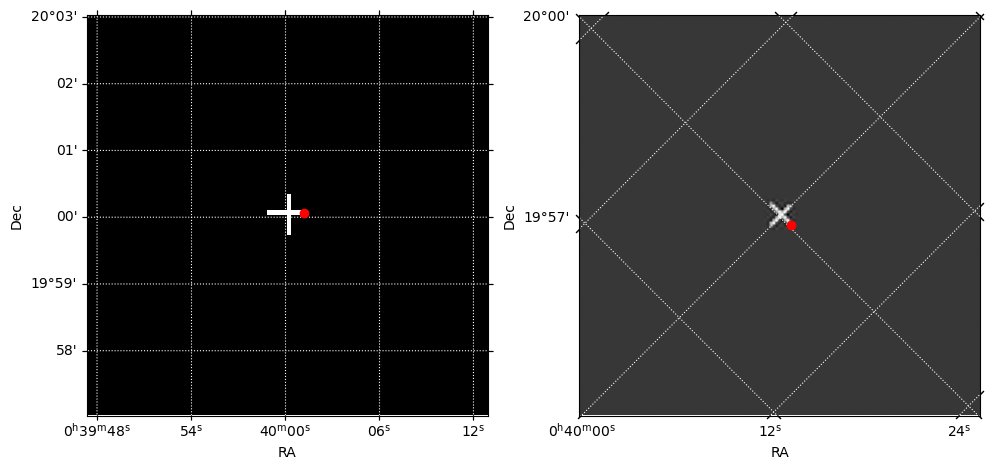

In [7]:
# Making a Figure
images = [(data1, hdr1), (data2, hdr2)]
point = [point_ra, point_dec]

n = len(images)
fig = plt.figure(figsize=(5*n, 5))

for i, (data, hdr) in enumerate(images, start=1):
    wcs = WCS(hdr)
    x, y = wcs.wcs_world2pix([point], 0)[0]
    # Create subplot in position i with its own WCS
    ax = fig.add_subplot(1, n, i, projection=wcs)
    ax.plot(x, y , 'ro', label='Punto RA/Dec')
    ax.imshow(data, origin='lower', cmap='gray')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(color='white', ls='dotted')

plt.tight_layout()

In [8]:
# Example 2
# --- Opening the FITS file---
stamp_file = 'stamp/PGC_038749_I_g_bbl2011_original.fits'
with fits.open(stamp_file) as hdul:
    data1 = hdul[0].data
    hdr1 = hdul[0].header.copy()

wcs1 = WCS(hdr1)

# Rotating
angle_deg = 45
hdu2 = vr.apply_correction_to_stamp(stamp_file, rotation_angle=angle_deg, from_data=False,
                              keep_size=False, interp_order=5, update_wcs=True)

# c = -1
hdu3 = vr.apply_correction_to_stamp(stamp_file, rotation_angle=angle_deg, from_data=True,
                              keep_size=False, interp_order=5, update_wcs=True, c=-1)

data2 = hdu2.data
hdr2 = hdu2.header.copy()
wcs2 = WCS(hdr2)

data3 = hdu3.data
hdr3 = hdu3.header.copy()
wcs3 = WCS(hdr3)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
# List of points on RA/Dec data ---
points = [
    (SkyCoord(ra=vr.RA_to_degree(12, 10, 41)*u.deg, dec=vr.Dec_to_degree(16, 0, 54)*u.deg), 'A'),
    #(SkyCoord(ra=150.15*u.deg, dec=2.36*u.deg), 'B'),
    #(SkyCoord(ra=150.10*u.deg, dec=2.32*u.deg), 'C')
]

# Convert RA/Dec to pixel coordinates (0-based)
c = points[0][0]
px_orig, py_orig = wcs1.world_to_pixel(c)
px_rot2, py_rot2 = wcs2.world_to_pixel(c)
px_rot3, py_rot3 = wcs3.world_to_pixel(c)

print("Original pixel:", px_orig, py_orig)
print("Rotated WCS pixel:", px_rot2, py_rot2)
print("Rotated WCS pixel:", px_rot3, py_rot3)
print()

# Coordenadas de píxel en la original
orig_val = data1[int(np.round(py_orig)), int(np.round(px_orig))]

# Coordenadas de píxel en la imagen rotada
rot_val2 = data2[int(np.round(py_rot2)), int(np.round(px_rot2))]
rot_val3 = data3[int(np.round(py_rot3)), int(np.round(px_rot3))]

print("Valor original:", orig_val)
print("Valor en imagen rotada:", rot_val2)
print("Valor en imagen rotada:", rot_val3)

Original pixel: 76.57749961819687 64.58524880894001
Rotated WCS pixel: 102.4191212423239 172.02019813115362
Rotated WCS pixel: 100.21201424237772 171.52019813108478

Valor original: 598.7114
Valor en imagen rotada: 155.19904
Valor en imagen rotada: 3542.731


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


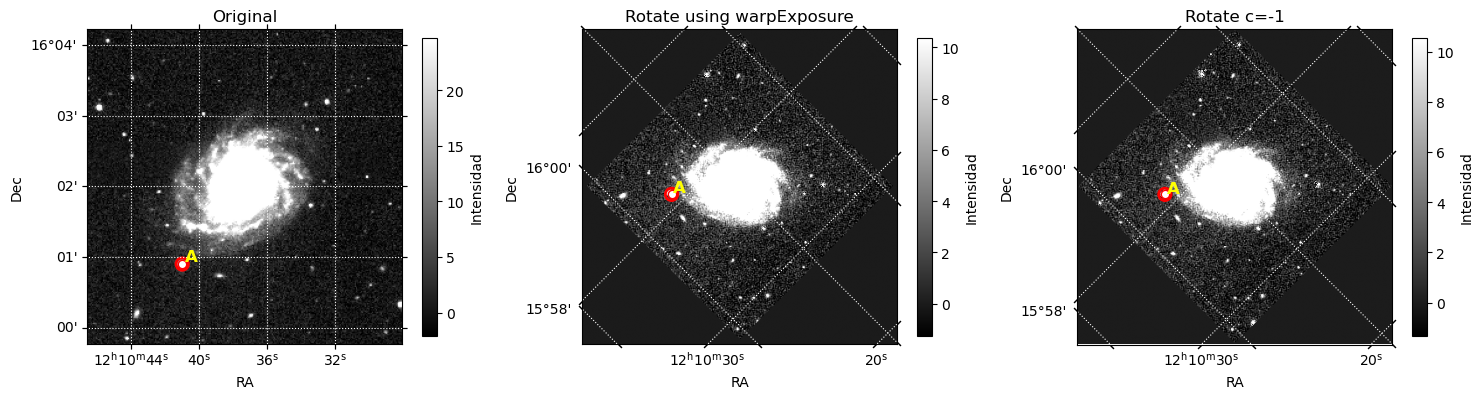

In [10]:
# Making a Figure
images = [(data1, hdr1), (data2, hdr2), (data3, hdr3)]
n = len(images)
fig = plt.figure(figsize=(5*n, 5))

title = ['Original', 'Rotate using warpExposure', 'Rotate c=-1', 'Rotate']
for i, (data, hdr) in enumerate(images, start=1):
    wcs = WCS(hdr)
    # Create subplot in position i with its own WCS
    ax = fig.add_subplot(1, n, i, projection=wcs)
    
    for c, label in points:
        x, y = wcs.world_to_pixel(c)
        ax.scatter(x, y, s=80, edgecolor='red', facecolor='none', linewidth=2)
        ax.text(x + 2, y + 2, label, color='yellow', fontsize=12, weight='bold')
    
        x_p, y_p = wcs.wcs_world2pix([[c.ra.deg, c.dec.deg]], 0)[0]
        ax.plot(x_p, y_p, 'ro', label='Punto RA/Dec', mfc='white')
        
    p5, p95 = np.percentile(data, [5, 95])
    im = ax.imshow(data, origin='lower', cmap='gray', vmin=p5, vmax=p95)

    ax.set_title(title[i-1])
    ax.set_xlabel(r'RA')
    ax.set_ylabel(r'Dec')
    ax.grid(color='white', ls='dotted')

    plt.colorbar(im, ax=ax, label='Intensidad', pad=0.05, shrink=0.7)

plt.tight_layout()